# Installations

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 --progress-bar off
!pip install sentencepiece --progress-bar off

# Imports

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import Dataset, load_dataset
import datasets
import sentencepiece

import torch
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare Data

## Load Data

In [ ]:
train_dataset = load_dataset("tasksource/bigbench", "sports_understanding", split="train", trust_remote_code=True)

test_dataset = load_dataset("lukaemon/bbh", "sports_understanding", split="test", trust_remote_code=True)
test_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split:   0%|          | 0/250 [00:00<?, ? examples/s]

Dataset({
    features: ['input', 'target'],
    num_rows: 250
})

In [ ]:
train_dataset

Dataset({
    features: ['inputs', 'targets', 'multiple_choice_targets', 'multiple_choice_scores', 'idx'],
    num_rows: 789
})

## Generate Instructions

In [ ]:
ANSWER_ONLY_PROMPT = """
Answer the following yes/no question with only yes or no.
""".strip()

def generate_ans_only_prompt(
    input, system_prompt: str = ANSWER_ONLY_PROMPT
) -> str:
    return f"""{system_prompt}
{input.strip()}

""".strip()
#######################################################################################

THREE_SHOT_PROMPT = """
Q: Answer the following yes/no question.
""".strip()

def generate_three_shot_prompt(
    input: str, examples: str, system_prompt: str = THREE_SHOT_PROMPT
) -> str:
    return f"""{examples}
{system_prompt}
{input}
A:
""".strip()
#######################################################################################

COT_PROMPT = """
Let's think step-by-step.
""".strip()

def generate_cot_prompt(
    input: str, system_prompt: str = COT_PROMPT
) -> str:
    return f"""{system_prompt}
{input.strip()}

""".strip()
#######################################################################################

THREE_COT_PROMPT = """
Q: Let's think step-by-step.
""".strip()
def generate_three_cot_prompt(
    input: str, examples: str, system_prompt: str = THREE_COT_PROMPT
) -> str:
    return f"""{examples}
{system_prompt}
{input}
A:
""".strip()

In [ ]:
PLAUSIBLE_PROMPT = "Is the following sentence plausible? \""

def generate_example(indices, prompt):

    example = ""
    for index in indices:
        ans = 'yes' if train_dataset[index]['targets'] == ['plausible'] else 'no'
        example += prompt + '\n' + PLAUSIBLE_PROMPT + \
                   train_dataset[index]['inputs'].split('\n')[1][11:] + '.\"\nA: ' + ans +'\n'

    return example.strip()


def prepare_data(data_point):
    input = data_point['input']
    target = data_point['target']
    indices = random.sample(range(0, len(train_dataset)), 3)
    examples =  generate_example(indices, THREE_SHOT_PROMPT)
    cot_examples =  generate_example(indices, THREE_COT_PROMPT)

    return {
        "answer_only": generate_ans_only_prompt(input),
        "three_shot" : generate_three_shot_prompt(input, examples),
        "cot_ans"    : generate_cot_prompt(input),
        "cot_three"  : generate_three_cot_prompt(input, cot_examples),
    }


def process_dataset(data: datasets.Dataset):
    return (
        data.shuffle(seed=12)
        .map(prepare_data)
    )

In [ ]:
test_dataset = process_dataset(test_dataset)

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [ ]:
test = pd.DataFrame({"input"      : test_dataset['input'],
                     "answer_only": test_dataset["answer_only"],
                     "three_shot" : test_dataset["three_shot"],
                     "cot_ans"    : test_dataset["cot_ans"],
                     "cot_three"  : test_dataset["cot_three"],
                     "target"     :test_dataset['target']})
test.to_csv('/content/drive/MyDrive/MSC/DGM/HW3/Q2/test_data1.csv', index=False)

# Utils

## Read Data

In [ ]:
test_dataset  = pd.read_csv('/content/drive/MyDrive/MSC/DGM/HW3/Q2/test_data1.csv')

test_dataset  = Dataset.from_pandas(test_dataset )

In [ ]:
test_dataset[0]

{'input': 'Is the following sentence plausible? "Ryan O\'Reilly hit the wheel route."',
 'answer_only': 'Answer the following yes/no question with only yes or no.\nIs the following sentence plausible? "Ryan O\'Reilly hit the wheel route."',
 'three_shot': 'Q: Answer the following yes/no question.\nIs the following sentence plausible? "Jonas Valanciunas beat the buzzer."\nA: yes\nQ: Answer the following yes/no question.\nIs the following sentence plausible? "Terry McLaurin committed a blocking foul in the Eastern Conference Finals."\nA: no\nQ: Answer the following yes/no question.\nIs the following sentence plausible? "Jaylen Brown was called for the goal tend."\nA: yes\nQ: Answer the following yes/no question.\nIs the following sentence plausible? "Ryan O\'Reilly hit the wheel route."\nA:',
 'cot_ans': 'Let\'s think step-by-step.\nIs the following sentence plausible? "Ryan O\'Reilly hit the wheel route."',
 'cot_three': 'Q: Let\'s think step-by-step.\nIs the following sentence plausibl

## Load Model

In [ ]:
MODEL_NAME = "google/flan-t5-large"

def load_model():
    model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME,
                                                       device_map="auto",
                                                       torch_dtype="auto",)
    tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    return model, tokenizer

## Generate Answer

In [ ]:
def generate_answer(model, prompt):
    inputs = tokenizer(prompt, return_tensors = 'pt').to(device)
    generated = model.generate(
            inputs['input_ids'],
            pad_token_id= tokenizer.pad_token_id,
            max_new_tokens = 50,)[0]
    output = tokenizer.decode(generated,skip_special_tokens = True)
    return output

# Evaluation

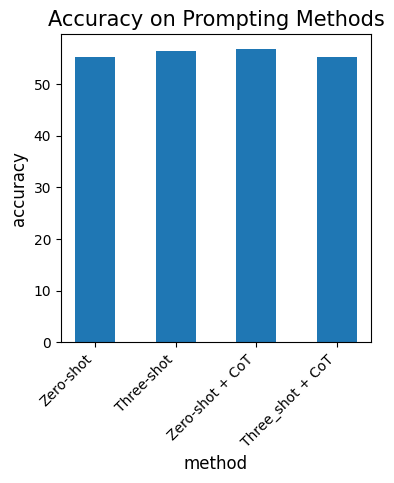

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
accuracies = [55.2, 56.4, 56.8, 55.2]
methods = ['Zero-shot', 'Three-shot', 'Zero-shot + CoT', 'Three_shot + CoT']
plt.bar(methods, accuracies, width=0.5)
plt.title('Accuracy on Prompting Methods', fontsize=15)
plt.xlabel('method', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.xticks(rotation=45, ha="right");

## Answer only

In [ ]:
model, tokenizer = load_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at google/flan-t5-large and are newly initialized: ['decoder.embed_tokens.weight', 'encoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


In [ ]:
dashline = '-'.join('' for x in range(100))
for i, data_point in enumerate(test_dataset.select([0,2,3])):

    prompt = data_point['answer_only']
    target = data_point['target']

    output = generate_answer(model, data_point['answer_only'])

    print(dashline)
    print("Example ", i+1)
    print()
    print(f'Input Prompt: \n{prompt}')
    print()
    print(f'Real target: \n{target}')
    print()
    print(f'Model generation target \n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1

Input Prompt: 
Answer the following yes/no question with only yes or no.
Is the following sentence plausible? "Zach LaVine  shot the puck."

Real target: 
no

Model generation target 
yes

---------------------------------------------------------------------------------------------------
Example  2

Input Prompt: 
Answer the following yes/no question with only yes or no.
Is the following sentence plausible? "Sterling Shepard hit a walkoff homer."

Real target: 
no

Model generation target 
No

---------------------------------------------------------------------------------------------------
Example  3

Input Prompt: 
Answer the following yes/no question with only yes or no.
Is the following sentence plausible? "Ryan Nugent-Hopkins killed the powerplay."

Real target: 
yes

Model generation target 
yes



In [ ]:
gt_target = []
predicted_target = []
with open('/content/drive/MyDrive/MSC/DGM/HW3/Q2/ans_only_test_output.txt', 'w') as f:
    for sample in test_dataset:
        gt_target.append(sample['target'])
        pred_target = generate_answer(model, sample['answer_only'])
        predicted_target.append(pred_target)
        f.write(f"{pred_target}\n")

In [ ]:
trgt = {'yes':1, 'no':0, 'Yes':1, 'No':0}
predicted_target_ = list(map(lambda x: trgt[x], predicted_target))
gt_target_ = list(map(lambda x: trgt[x], gt_target))

print("Prediction Accuracy: ", accuracy_score(gt_target_ , predicted_target_)*100)

Prediction Accuracy:  55.2


## Three Shot

In [ ]:
model, tokenizer = load_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at google/flan-t5-large and are newly initialized: ['decoder.embed_tokens.weight', 'encoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
dashline = '-'.join('' for x in range(100))
for i, data_point in enumerate(test_dataset.select([0,2,3])):

    prompt = data_point['three_shot']
    target = data_point['target']

    output = generate_answer(model, data_point['three_shot'])

    print(dashline)
    print("Example ", i+1)
    print()
    print(f'Input Prompt: \n{prompt}')
    print()
    print(f'Real target: \n{target}')
    print()
    print(f'Model generation target \n{output}\n')

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


---------------------------------------------------------------------------------------------------
Example  1

Input Prompt: 
Q: Answer the following yes/no question.
Is the following sentence plausible? "Daniel Jones took a left footed shot."
A: no
Q: Answer the following yes/no question.
Is the following sentence plausible? "Sergio Aguero hit the buzzer beater in the NBA Championship."
A: no
Q: Answer the following yes/no question.
Is the following sentence plausible? "Keenan Allen was called for slashing in the Stanley Cup."
A: no
Q: Answer the following yes/no question.
Is the following sentence plausible? "Zach LaVine  shot the puck."
A:

Real target: 
no

Model generation target 
yes

---------------------------------------------------------------------------------------------------
Example  2

Input Prompt: 
Q: Answer the following yes/no question.
Is the following sentence plausible? "Mookie Betts skated behind the net."
A: no
Q: Answer the following yes/no question.
Is the fo

In [ ]:
gt_target = []
predicted_target = []
with open('/content/drive/MyDrive/MSC/DGM/HW3/Q2/three_shot_test_output.txt', 'w') as f:
    for sample in test_dataset:
        gt_target.append(sample['target'])
        pred_target = generate_answer(model, sample['three_shot'])
        predicted_target.append(pred_target)
        f.write(f"{pred_target}\n")

In [ ]:
trgt = {'yes':1, 'no':0, 'Yes':1, 'No':0}
predicted_target_ = list(map(lambda x: trgt[x], predicted_target))
gt_target_ = list(map(lambda x: trgt[x], gt_target))

print("Predicted Accuracy: ", accuracy_score(gt_target_ , predicted_target_))

Predicted Accuracy:  0.564


## CoT

In [ ]:
model, tokenizer = load_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at google/flan-t5-large and are newly initialized: ['decoder.embed_tokens.weight', 'encoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


In [ ]:
dashline = '-'.join('' for x in range(100))
for i, data_point in enumerate(test_dataset.select([0,2,3])):

    prompt = data_point['cot_ans']
    target = data_point['target']

    output = generate_answer(model, data_point['cot_ans'])

    print(dashline)
    print("Example ", i+1)
    print()
    print(f'Input Prompt: \n{prompt}')
    print()
    print(f'Real target: \n{target}')
    print()
    print(f'Model generation target \n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1

Input Prompt: 
Answer the following yes/no question by reasoning step-by-step.
Is the following sentence plausible? "Zach LaVine  shot the puck."

Real target: 
no

Model generation target 
Zach LaVine is a professional ice hockey player. Therefore, the final answer is yes.

---------------------------------------------------------------------------------------------------
Example  2

Input Prompt: 
Answer the following yes/no question by reasoning step-by-step.
Is the following sentence plausible? "Sterling Shepard hit a walkoff homer."

Real target: 
no

Model generation target 
Sterling Shepard is a famous baseball player who hit a walkoff homer. Therefore, the final answer is yes.

---------------------------------------------------------------------------------------------------
Example  3

Input Prompt: 
Answer the following yes/no question by reasoning step-by-step.
Is

In [ ]:
gt_target = []
predicted_target = []
with open('/content/drive/MyDrive/MSC/DGM/HW3/Q2/cot_ans_test_output.txt', 'w') as f:
    for sample in test_dataset:
        gt_target.append(sample['target'])
        output = generate_answer(model, sample['cot_ans'])
        predicted_target.append(output[output.find('final answer is ')+16:].split('.')[0])
        f.write(f"{output}\n")

In [ ]:
trgt = {'yes':1, 'no':0, 'Yes':1, 'No':0}
predicted_target_ = list(map(lambda x: trgt[x], predicted_target))
gt_target_ = list(map(lambda x: trgt[x], gt_target))

print("Prediction Accuracy: ", accuracy_score(gt_target_ , predicted_target_)*100)

Prediction Accuracy:  53.2


#### new

In [ ]:
dashline = '-'.join('' for x in range(100))
for i, data_point in enumerate(test_dataset.select([0,2,3])):

    prompt = data_point['cot_ans']
    target = data_point['target']

    output = generate_answer(model, data_point['cot_ans'])

    print(dashline)
    print("Example ", i+1)
    print()
    print(f'Input Prompt: \n{prompt}')
    print()
    print(f'Real target: \n{target}')
    print()
    print(f'Model generation target \n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1

Input Prompt: 
Let's think step-by-step.
Is the following sentence plausible? "Ryan O'Reilly hit the wheel route."

Real target: 
no

Model generation target 
Ryan O'Reilly is a comedian and not a driver. So, the answer is no.

---------------------------------------------------------------------------------------------------
Example  2

Input Prompt: 
Let's think step-by-step.
Is the following sentence plausible? "Kyle Connor eurostepped to the basket in the Western Conference Finals."

Real target: 
no

Model generation target 
Kyle Connor is a professional basketball player and has never eurostepped. So, the answer is no.

---------------------------------------------------------------------------------------------------
Example  3

Input Prompt: 
Let's think step-by-step.
Is the following sentence plausible? "Khyri Thomas  changed direction in the backfield in the NFC cha

In [ ]:
gt_target = []
predicted_target = []
with open('/content/drive/MyDrive/MSC/DGM/HW3/Q2/cot_ans_test_output.txt', 'w') as f:
    for sample in test_dataset:
        gt_target.append(sample['target'])
        output = generate_answer(model, sample['cot_ans'])
        predicted_target.append(output[output.find('the answer is ')+14:].split('.')[0])
        f.write(f"{output}\n")

In [ ]:
trgt = {'yes':1, 'no':0, 'Yes':1, 'No':0}
predicted_target_ = list(map(lambda x: trgt[x], predicted_target))
gt_target_ = list(map(lambda x: trgt[x], gt_target))

print("Prediction Accuracy: ", accuracy_score(gt_target_ , predicted_target_)*100)

Prediction Accuracy:  56.8


## Three CoT

In [ ]:
model, tokenizer = load_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at google/flan-t5-large and are newly initialized: ['decoder.embed_tokens.weight', 'encoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
dashline = '-'.join('' for x in range(100))
for i, data_point in enumerate(test_dataset.select([0,2,3])):

    prompt = data_point['cot_three']
    target = data_point['target']

    output = generate_answer(model, data_point['cot_three'])

    print(dashline)
    print("Example ", i+1)
    print()
    print(f'Input Prompt: \n{prompt}')
    print()
    print(f'Real target: \n{target}')
    print()
    print(f'Model generation target \n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1

Input Prompt: 
Q: Answer the following yes/no question by reasoning step-by-step.
Is the following sentence plausible? "Daniel Jones took a left footed shot."
A: no
Q: Answer the following yes/no question by reasoning step-by-step.
Is the following sentence plausible? "Sergio Aguero hit the buzzer beater in the NBA Championship."
A: no
Q: Answer the following yes/no question by reasoning step-by-step.
Is the following sentence plausible? "Keenan Allen was called for slashing in the Stanley Cup."
A: no
Q: Answer the following yes/no question by reasoning step-by-step.
Is the following sentence plausible? "Zach LaVine  shot the puck."
A:

Real target: 
no

Model generation target 
yes Because he is a professional ice hockey player. So the answer is yes.

---------------------------------------------------------------------------------------------------
Example  2

Input Prompt:

In [ ]:
gt_target = []
predicted_target = []
with open('/content/drive/MyDrive/MSC/DGM/HW3/Q2/cot_three_test_output.txt', 'w') as f:
    for sample in test_dataset:
        gt_target.append(sample['target'])
        output = generate_answer(model, sample['cot_three'])
        predicted_target.append(output[:3])
        f.write(f"{output}\n")

In [ ]:
trgt = {'yes':1, 'no ':0,'no':0, 'Yes':1, 'No':0}
predicted_target_ = list(map(lambda x: trgt[x], predicted_target))
gt_target_ = list(map(lambda x: trgt[x], gt_target))

print("Prediction Accuracy: ", accuracy_score(gt_target_ , predicted_target_)*100)

Prediction Accuracy:  55.2


#### New

In [ ]:
dashline = '-'.join('' for x in range(100))
for i, data_point in enumerate(test_dataset.select([0,2,3])):

    prompt = data_point['cot_three']
    target = data_point['target']

    output = generate_answer(model, data_point['cot_three'])

    print(dashline)
    print("Example ", i+1)
    print()
    print(f'Input Prompt: \n{prompt}')
    print()
    print(f'Real target: \n{target}')
    print()
    print(f'Model generation target \n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1

Input Prompt: 
Q: Let's think step-by-step.
Is the following sentence plausible? "Jonas Valanciunas beat the buzzer."
A: yes
Q: Let's think step-by-step.
Is the following sentence plausible? "Terry McLaurin committed a blocking foul in the Eastern Conference Finals."
A: no
Q: Let's think step-by-step.
Is the following sentence plausible? "Jaylen Brown was called for the goal tend."
A: yes
Q: Let's think step-by-step.
Is the following sentence plausible? "Ryan O'Reilly hit the wheel route."
A:

Real target: 
no

Model generation target 
no Ryan O'Reilly is a politician and not a hit man.

---------------------------------------------------------------------------------------------------
Example  2

Input Prompt: 
Q: Let's think step-by-step.
Is the following sentence plausible? "Klaas Jan Huntelaar dunked the ball."
A: no
Q: Let's think step-by-step.
Is the following sentence 

In [ ]:
gt_target = []
predicted_target = []
with open('/content/drive/MyDrive/MSC/DGM/HW3/Q2/cot_three_test_output.txt', 'w') as f:
    for sample in test_dataset:
        gt_target.append(sample['target'])
        output = generate_answer(model, sample['cot_three'])
        print(sample['cot_three'])
        predicted_target.append(output[:3])
        f.write(f"{output}\n")

Q: Let's think step-by-step.
Is the following sentence plausible? "Jonas Valanciunas beat the buzzer."
A: yes
Q: Let's think step-by-step.
Is the following sentence plausible? "Terry McLaurin committed a blocking foul in the Eastern Conference Finals."
A: no
Q: Let's think step-by-step.
Is the following sentence plausible? "Jaylen Brown was called for the goal tend."
A: yes
Q: Let's think step-by-step.
Is the following sentence plausible? "Ryan O'Reilly hit the wheel route."
A:
Q: Let's think step-by-step.
Is the following sentence plausible? "Jack Eichel got into the endzone."
A: no
Q: Let's think step-by-step.
Is the following sentence plausible? "John Tavares earned a trip to the penalty box in the Stanley Cup."
A: yes
Q: Let's think step-by-step.
Is the following sentence plausible? "Willian took a left footed shot in the Champions League Final."
A: yes
Q: Let's think step-by-step.
Is the following sentence plausible? "Calvin Ridley skated behind the net."
A:
Q: Let's think step-by

In [ ]:
trgt = {'yes':1, 'no ':0,'no':0, 'Yes':1, 'No':0}
predicted_target_ = list(map(lambda x: trgt[x], predicted_target))
gt_target_ = list(map(lambda x: trgt[x], gt_target))

print("Prediction Accuracy: ", accuracy_score(gt_target_ , predicted_target_)*100)

Prediction Accuracy:  55.2
